# Notes Before Running:

Before running, I suggest you have the files preprocessed_data.txt and target.txt in the same directory as this
file so you don't have to waste time generating the preprocessed data and targets

# Importing Packages

In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import regularizers
## Requires TwoRoundAES.py (included in the zip file)
from TwoRoundAES import TwoRoundAES

2022-12-17 22:24:39.921587: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
## Function to calculate the hamming weight of a list of bytes
def HW(bytes):
    binary_bytes = ""
    hw = 0
    for x in bytes:
        binary_bytes += bin(x)[2:]

    for x in binary_bytes:
        if x == '1':
            hw += 1

    return hw

# Testing AES and HW Implementation

In [64]:
plaintext = pd.read_csv("001_plain.txt", header=None, sep=' ')
ciphertext = pd.read_csv("001_cipher.txt", header=None, sep=' ')
key = [0x00, 0x01, 0x02, 0x03, 0x04, 0x05, 0x06, 0x07, 0x08, 0x09, 0x0A, 0x0B, 0x0C, 0x0D, 0x0E, 0x0F]
aes = TwoRoundAES()

## The real ciphertext and my ciphertext should be the same. If not, check TwoRoundAES.py
print("Plaintext: ", plaintext.iloc[0].to_numpy())
print("Real ciphertext: ", ciphertext.iloc[0].to_numpy())
print("My ciphertext: ", aes.enc(key, plaintext.iloc[0].to_numpy(), rounds=10))
print("Hamming weight: ", HW(aes.enc(key, plaintext.iloc[0].to_numpy(), rounds=10)))
print("2 Round encryption: ", aes.enc(key, plaintext.iloc[0].to_numpy(), rounds=2))

Plaintext:  [253 110   6 137  98 242  99  61 245 169 175 139  29 252 181  33]
Real ciphertext:  [ 26  68 116 209  44 188 127 153 140  86 177  13  78  68   0  28]
My ciphertext:  [26, 68, 116, 209, 44, 188, 127, 153, 140, 86, 177, 13, 78, 68, 0, 28]
Hamming weight:  55
2 Round encryption:  [178, 141, 3, 186, 76, 99, 52, 192, 178, 187, 87, 64, 225, 114, 254, 171]


# Data Inspection

In [4]:
## Raw powertrace data from source
pre_df = pd.read_csv("001_trace_int.txt", header=None, sep=' ')

In [5]:
pre_df

,0,1,2,3,4,5,6,7,8,9,...,3115,3116,3117,3118,3119,3120,3121,3122,3123,3124
0,32723,32723,32778,32778,32778,32723,32778,32723,32833,32723,...,32750,32723,32750,32723,32750,32778,32723,32805,32805,32750
1,32750,32750,32723,32805,32750,32805,32750,32805,32750,32778,...,32833,32778,32778,32805,32778,32805,32750,32805,32750,32750
2,32778,32750,32750,32805,32750,32778,32860,32860,32778,32778,...,32778,32833,32750,32750,32778,32723,32778,32696,32833,32833
3,32778,32860,32778,32860,32750,32805,32778,32805,32778,32778,...,32750,32778,32750,32778,32750,32805,32723,32778,32778,32750
4,32778,32750,32805,32778,32778,32778,32778,32805,32805,32778,...,32805,32750,32778,32778,32750,32778,32805,32750,32778,32887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,32750,32778,32696,32723,32723,32750,32778,32778,32778,32723,...,32696,32750,32696,32778,32750,32750,32750,32750,32805,32778
49996,32778,32750,32750,32778,32723,32723,32750,32723,32750,32778,...,32778,32833,32750,32750,32805,32805,32750,32805,32778,32723
49997,32778,32778,32860,32723,32723,32696,32750,32750,32833,32778,...,32805,32805,32723,32805,32778,32750,32750,32805,32805,32750
49998,32833,32778,32723,32723,32696,32723,32723,32723,32805,32805,...,32750,32778,32750,32723,32723,32750,32696,32723,32723,32778


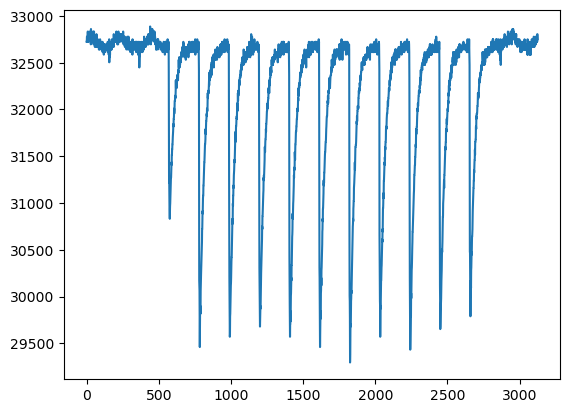

In [6]:
## Plotting raw power trace
plt.plot(pre_df.iloc[0])

/home/jake/anaconda3/envs/myenv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


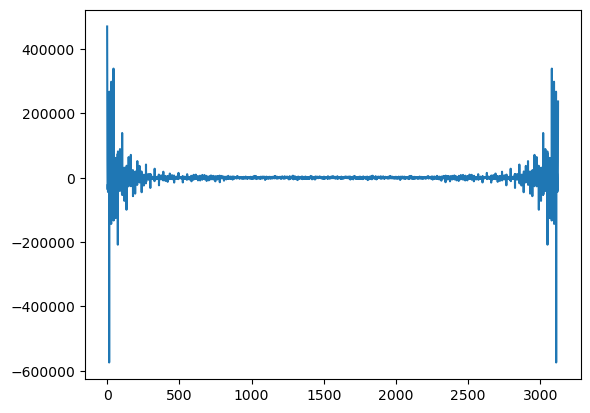

In [7]:
## Plotting Fourier Transform of a power trace
powertrace = pre_df.iloc[0].to_numpy()
fft = np.fft.fft(powertrace)
plt.plot(fft[1:-1])

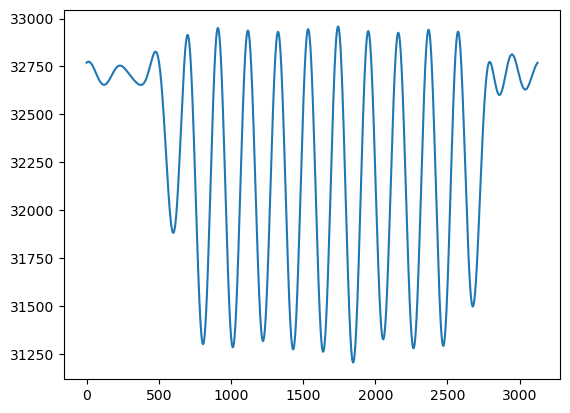

In [8]:
## Smooth Fourier Transform for easier preprocessing
fft[20: 3125 - 20] = 0
plt.plot(np.fft.ifft(fft))
ifft = np.fft.ifft(fft)

# Preprocessing

In [9]:
cols = [str(x) for x in range(50)]
df = pd.DataFrame(columns=cols)

In [10]:
## Generates the preprocessed data from the raw powertraces to preprocessed_data.txt
## Takes 50 random samples from the 2nd round of AES (2nd - 3rd hump on previous graph)
def create_preprocessed_data():
    peaks = []
    data = []
    data_range = []
    sample = []
    chosen_data = []
    fft = []
    ifft = []
    for index, row in pre_df.iterrows():
        fft = np.fft.fft(row.to_numpy())
        fft[20: len(fft) - 20] = 0
        ifft = np.fft.fft(fft)
        peaks = [x for x in find_peaks(ifft, distance=150)[0] if x >= 500][0:11]
        data = powertrace[peaks[2]:peaks[3]]
        data_range = [x for x in range(len(data))]
        sample = np.sort(np.random.choice(data_range, 50, replace=False))
        chosen_data = data[sample]
        df.loc[len(df)] = chosen_data

    df.to_csv("preprocessed_data.txt", index=False, header=False, sep=' ')

In [11]:
if not os.path.exists("preprocessed_data.txt"):
    create_preprocessed_data()
df = pd.read_csv("preprocessed_data.txt", header=None, sep=' ')

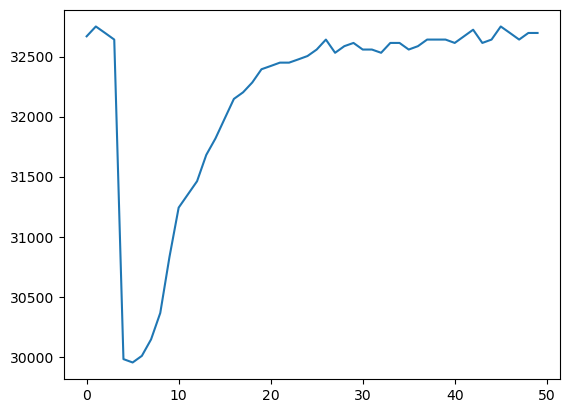

In [12]:
## Plotting example preprocessed input
row = random.randint(0, len(df))
plt.plot(df.iloc[row])

# Generating Key Guesses and Target

In [13]:
## Assuming 8 known bytes, 7 static random unknown bytes, and 1 variable byte
unknown_key_bytes = 8
fixed_key_bytes = 7
known_key = [0x00, 0x01, 0x02, 0x03, 0x04, 0x05, 0x06, 0x07, 0x08, 0x09, 0x0A, 0x0B, 0x0C, 0x0D, 0x0E, 0x0F]
final_key = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

for i in range(16-unknown_key_bytes):
    final_key[i] = known_key[i]

for i in range(16-unknown_key_bytes, 16 - unknown_key_bytes + fixed_key_bytes):
    final_key[i] = random.getrandbits(8)

## iterating through all 256 values of the last byte to generate the 256 key guesses
key_guesses = [[x for x in final_key] for y in range(256)]
for i in range(256):
    key_guesses[i][15] = i
print("key guesses")
key_guesses = np.array(key_guesses)
key_guesses

key guesses


array([[  0,   1,   2, ..., 175, 240,   0],
       [  0,   1,   2, ..., 175, 240,   1],
       [  0,   1,   2, ..., 175, 240,   2],
       ...,
       [  0,   1,   2, ..., 175, 240, 253],
       [  0,   1,   2, ..., 175, 240, 254],
       [  0,   1,   2, ..., 175, 240, 255]])

In [14]:
cols = [str(x) for x in range(256)]
target = pd.DataFrame(columns=cols)

In [15]:
## Creates the target data (y_true)
## WARNING!! TAKES A LONG TIME TO RUN, RECOMMENDED TO HAVE "target.txt" IN THE SAME DIRECTORY
def create_target():
    insert = np.array([0 for x in range(256)])
    temp = 0
    ## for each plaintext, encrypt with the 1st and 2nd round of aes and save the hamming weight of the output
    for index, row in plaintext.iterrows():
        i = 0
        print(temp)
        for key_guess in key_guesses:
            insert[i] = HW(aes.enc(key_guess, row, rounds=2))
            i += 1
        target.loc[len(target)] = insert
        temp += 1

    target.to_csv("target.txt", index=False, header=None, sep=' ')

In [16]:
## Categorizes hamming weights into quartiles
def quantize_hamming_weight(hw):
    if hw <= 32:
        return 0
    elif hw > 32 and hw <= 64:
        return 1
    elif hw > 64 and hw <= 96:
        return 2
    else:
        return 3


In [17]:
if not os.path.exists("target.txt"):
    create_target()

target = pd.read_csv("target.txt", header=None, sep=' ')

for (colName, colData) in target.iteritems():
    target[colName] = target[colName].apply(quantize_hamming_weight)

/tmp/ipykernel_150782/1462504409.py:6: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (colName, colData) in target.iteritems():


In [18]:
target

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,1,2,1,1,1,2,1,1,1,1,...,2,1,1,1,1,1,2,1,2,2
1,1,2,1,1,1,2,1,1,1,1,...,2,1,1,1,1,1,2,1,2,2
2,1,1,1,1,1,1,1,2,2,1,...,2,2,1,1,2,2,1,2,1,1
3,1,1,2,2,2,1,1,2,1,1,...,1,2,1,2,2,2,2,2,1,2
4,2,1,1,1,2,2,2,2,1,1,...,2,2,1,2,2,2,1,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,2,1,2,2,2,2,2,2,2,...,2,2,1,2,2,2,1,2,2,2
49996,1,2,1,2,2,2,1,1,2,2,...,2,1,1,1,2,2,2,1,2,2
49997,1,1,1,1,2,1,2,2,2,2,...,2,2,1,2,1,1,2,2,1,1
49998,1,2,2,2,2,1,1,1,2,1,...,2,1,1,1,2,1,2,2,1,2


# Neural Network

In [36]:
## Neural Network to find mapping between power traces and S-box output hamming weights
class Model():
    def __init__(self):
        ## Neural Network design (# nodes, # layers, L2 regularizer, and learning rate) have not been optimized due
        # to time restrictions
        self.model = None
        self.model = Sequential()
        self.model.add(Dense(100, input_shape=(50,), activation="relu"))
        self.model.add(Dense(100, activation="relu"))
        self.model.add(Dense(4, activation="softmax", kernel_regularizer=regularizers.L2(1e-4)))

        optimizer = SGD()
        self.model.summary()
        self.model.compile(loss="hinge", optimizer=optimizer, metrics=['accuracy'])

    def train(self, x, y):
        ## Batch size and epochs have not been optimized due to time restrictions
        batch_size = 200
        epochs = 25
        history = self.model.fit(x, y, batch_size=batch_size, epochs=epochs, validation_split=.2)
        return history

    def predict(self, x):
        prediction = np.argmax(self.model.predict(x))
        return prediction

    def get_model(self):
        return self.model

In [37]:
# Splitting data into train and test sets
all_indices = [x for x in range(50000)]
test_indices = np.random.choice(all_indices, int(50000 * 0.2), replace=False)

x_test = df.iloc[test_indices]
x_test = x_test.to_numpy()
y_test = target.iloc[test_indices]
y_test = y_test.to_numpy()
x_train = df.drop(test_indices, axis=0)
x_train = x_train.to_numpy()
y_train = target.drop(test_indices, axis=0)
y_train = y_train.to_numpy()

In [38]:
y_test[:,0]

array([2, 1, 1, ..., 2, 1, 1])

# Training Models

In [39]:
## Training 256 models, one for each key guess
models = []

for i in range(256):
    shuffler = np.random.permutation(len(x_train))
    x_train = x_train[shuffler]
    y_train = y_train[shuffler]
    model = Model()
    model.train(x_train, y_train[:,i])
    models.append(model)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 100)               5100      
                                                                 
 dense_13 (Dense)            (None, 100)               10100     
                                                                 
 dense_14 (Dense)            (None, 4)                 404       
                                                                 
Total params: 15,604
Trainable params: 15,604
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
160/160 [==============================] - 1s 5ms/step - loss: 0.7509 - accuracy: 0.4734 - val_loss: 0.7509 - val_accuracy: 0.4764
Epoch 2/25
160/160 [==============================] - 0s 3ms/step - loss: 0.7509 - accuracy: 0.4734 - val_loss: 0.7509 - val_accuracy: 0.4764
Epoch 3/25
160/160 [==========

In [40]:
## Evaluating all models using test set
accuracies = []
for i in range(256):
    metrics = models[i].model.evaluate(x=x_test, y=y_test[:,i])
    accuracies.append(metrics[1])

accuracies

313/313 [==============================] - 1s 3ms/step - loss: 0.7508 - accuracy: 0.4711


[0.46480000019073486,
 0.0,
 0.4629000127315521,
 0.5343000292778015,
 0.0,
 0.0,
 0.0,
 0.5350000262260437,
 0.0,
 0.0,
 0.0,
 0.0,
 0.5421000123023987,
 0.0,
 0.5357000231742859,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.5354999899864197,
 0.0,
 0.0,
 0.531000018119812,
 0.5253000259399414,
 0.0,
 0.0,
 0.5343000292778015,
 0.0,
 0.5385000109672546,
 0.46309998631477356,
 0.0,
 0.5358999967575073,
 0.0,
 0.46000000834465027,
 0.0,
 0.0,
 0.0,
 0.5379999876022339,
 0.0,
 0.4659000039100647,
 0.0,
 0.0,
 0.4636000096797943,
 0.0,
 0.0,
 0.5311999917030334,
 0.4643000066280365,
 0.5300999879837036,
 0.0,
 0.5364000201225281,
 0.0,
 0.5410000085830688,
 0.0,
 0.5357000231742859,
 0.5414000153541565,
 0.0,
 0.0,
 0.5353999733924866,
 0.4733999967575073,
 0.4691999852657318,
 0.0,
 0.0,
 0.5360000133514404,
 0.5300999879837036,
 0.0,
 0.0,
 0.0,
 0.0,
 0.5325000286102295,
 0.5310999751091003,
 0.0,
 0.4634000062942505,
 0.5507000088691711,
 0.5320000052452087,
 0.0,
 0.5328999757766724,

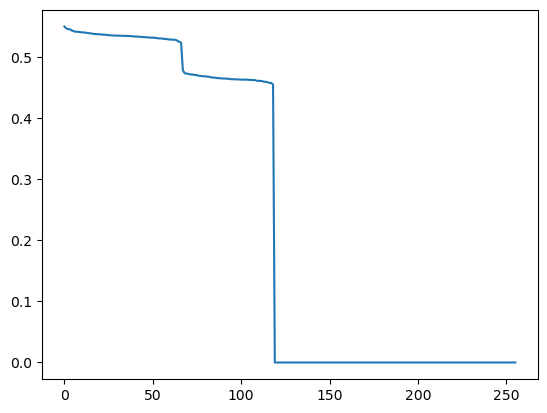

In [65]:
## sorting by accuracy best to worst
accuracies = np.array(accuracies)
best_indices = (-accuracies).argsort()
plt.plot(accuracies[best_indices])

In [63]:
## Saving best model
models[best_indices[0]].model.save("best_model.bin")

INFO:tensorflow:Assets written to: best_model.bin/assets
